In [280]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px

from ucimlrepo import fetch_ucirepo 

colors = ['#dd4444', '#f48080', '#ffdcdc', '#009999', '#194b4f']

colors.reverse()

cmap = mcolors.LinearSegmentedColormap.from_list(
    "diverging", colors
)

# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
df = heart_disease.data.features.copy()
res = heart_disease.data.targets
df = df.merge(res, left_index=True, right_index=True)
df.dropna(inplace=True)

res = df['num'] # target variable
df.drop(columns=['num'], inplace=True)

heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


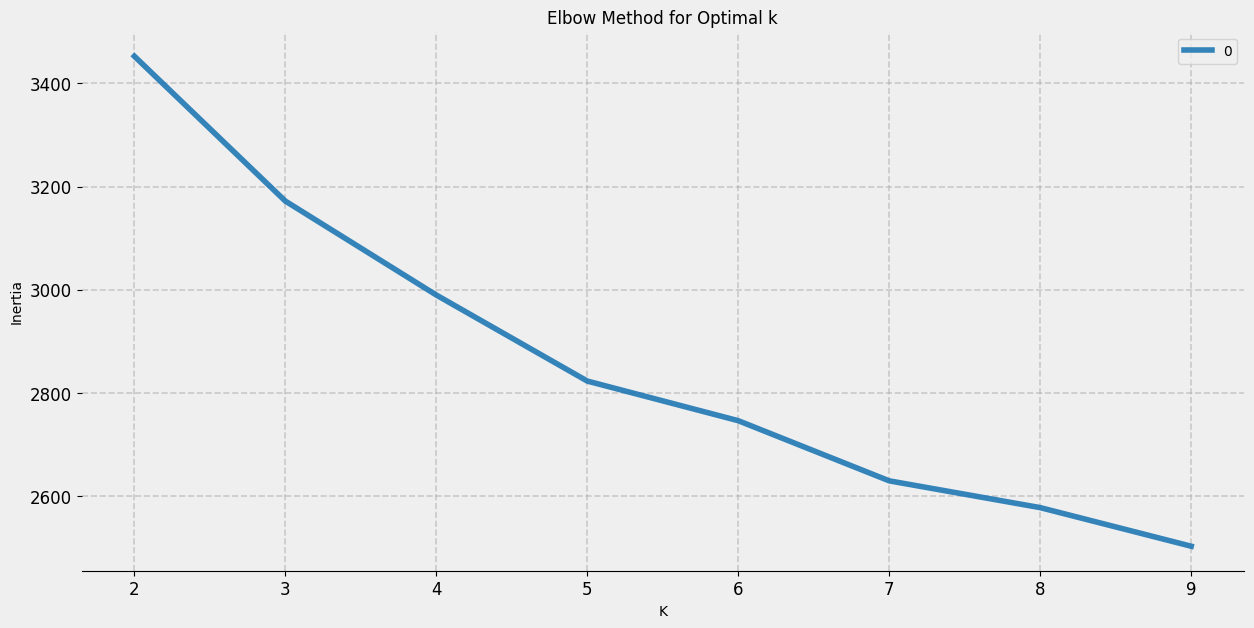

In [279]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Elbow method to determine optimal k number of clusters

inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(15,7))

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

data = pd.DataFrame(data = inertia, index = K)

ax = sns.lineplot(
    data = data, color = colors[2], alpha=0.9, linewidth= 4
             )
sns.set_style(rc={'axes.facecolor':'#efefef','figure.facecolor': '#efefef'})

plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
sns.despine(left=True)
plt.grid(linewidth=1.2, alpha=0.6, linestyle='--')

plt.savefig(r'elbow_plot.png', transparent=True, bbox_inches='tight')


In [257]:
# From the elbow plot, we choose k 
K = 5

km = KMeans(n_clusters = K, random_state=0)
df['cluster'] = km.fit_predict(df)
summarexpected_output = df.groupby('cluster').agg(['mean', 'std', 'count'])
summarexpected_output

age                       sex                        cp  \
              mean       std count      mean       std count      mean   
cluster                                                                  
0        59.840000  6.979153    50  0.740000  0.443087    50  3.340000   
1        56.312500  8.723031    64  0.578125  0.497763    64  3.203125   
2        52.988095  9.534331    84  0.726190  0.448591    84  3.166667   
3        62.600000  4.159327     5  0.000000  0.000000     5  3.600000   
4        51.478723  8.317269    94  0.702128  0.459775    94  3.000000   

                           trestbps  ... oldpeak     slope                  \
              std count        mean  ...   count      mean       std count   
cluster                              ...                                     
0        1.022402    50  135.840000  ...      50  1.880000  0.558423    50   
1        0.962465    64  137.843750  ...      64  1.515625  0.590727    64   
2        0.967338    84  127.869048  ...      84  1.595238  0.623226    84   
3        0.547723     5  135.800000  ...       5  1.800000  0.447214     5   
4        0.939000    94  128.500000  ...      94  1.510638  0.634911    94   

               ca                      thal                  
             mean       std count      mean       std count  
cluster                                                      
0        0.880000  0.961292    50  5.400000  1.916630    50  
1        0.828125  1.047365    64  4.718750  1.971775    64  
2        0.535714  0.856533    84  4.750000  1.913018    84  
3        1.200000  1.303840     5  5.400000  2.190890     5  
4        0.563830  0.874471    94  4.329787  1.868749    94  

[5 rows x 39 columns]

Text(0.5, 1.0, 'Clusters (2D projection)')

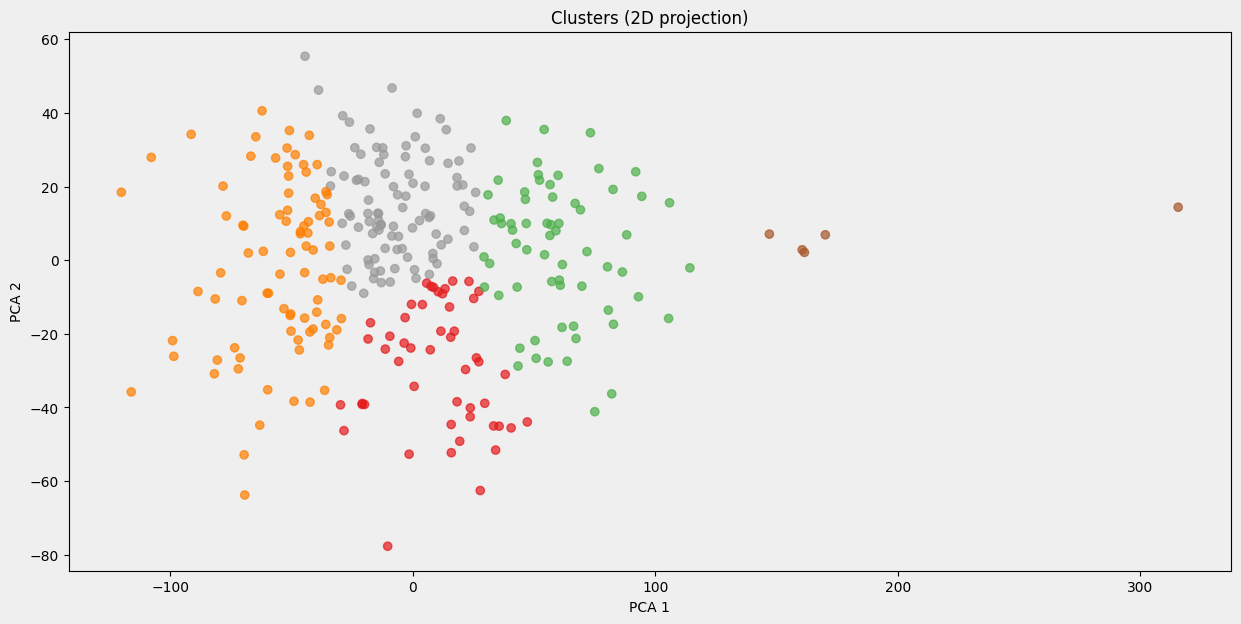

In [258]:
# PCA for 2D visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=['cluster']))

plt.figure(figsize=(15,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap="Set1", alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters (2D projection)')

Text(0.5, 1.0, 'Clusters (t-SNE projection)')

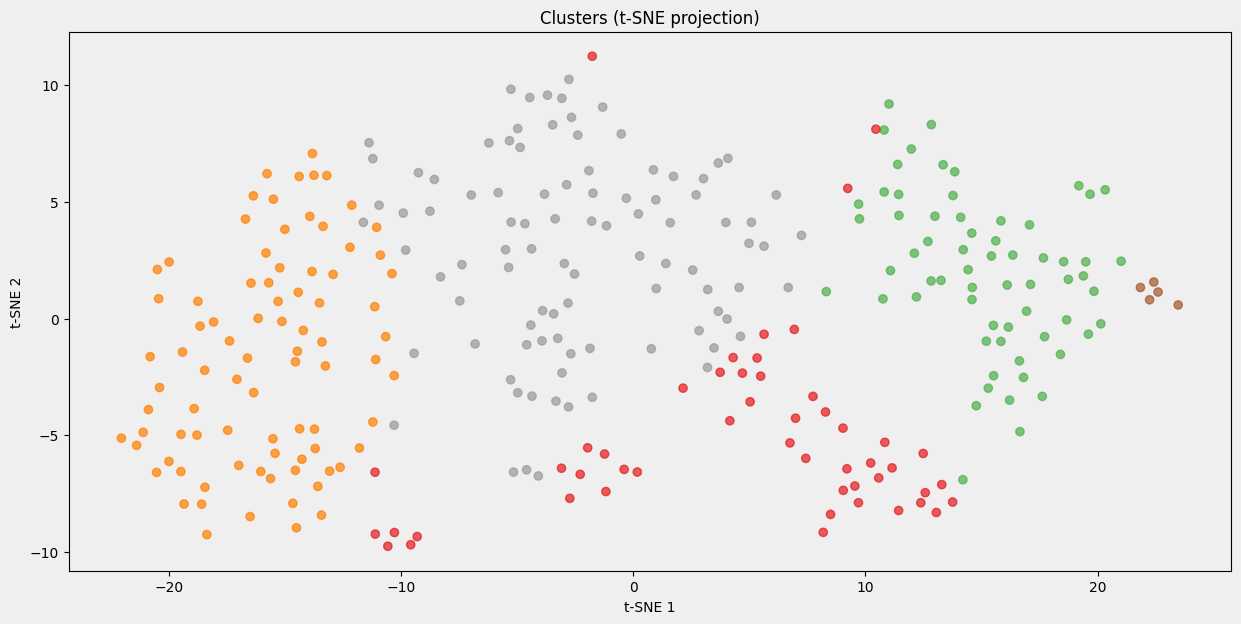

In [259]:
# t-SNE for high-dimensional data visualization

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["cluster"], cmap='Set1', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

In [260]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
df_without_cluster = df.drop(columns=['cluster'])
rf.fit(df_without_cluster, df['cluster'])

perm = permutation_importance(rf, df_without_cluster, df['cluster'], n_repeats=10, random_state=0)
importances = pd.Series(perm.importances_mean, index=df_without_cluster.columns).sort_values(ascending=False)

print("\nPermutation Importances:")
print(importances)


Permutation Importances:
chol        0.590909
thalach     0.229966
age         0.019192
trestbps    0.004040
oldpeak     0.002357
sex         0.000000
cp          0.000000
restecg     0.000000
fbs         0.000000
exang       0.000000
slope       0.000000
ca          0.000000
thal        0.000000
dtype: float64


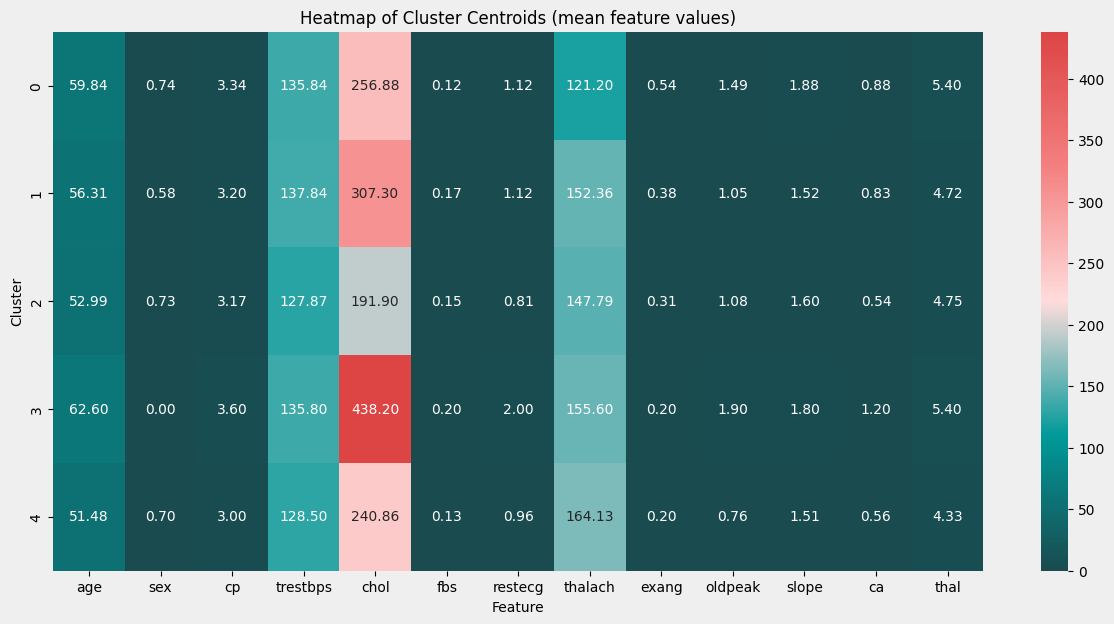

In [261]:
plt.figure(figsize=(15,7))
cluster_means = df.groupby('cluster').mean()
sns.heatmap(cluster_means, annot=True, cmap=cmap, cbar=True, fmt=".2f")
plt.title("Heatmap of Cluster Centroids (mean feature values)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.savefig(r'heatmap_of_cluster.png', transparent=True, bbox_inches='tight')